# Week 11 - Survival Analysis - Daniel Solis Toro
## Exercise 13-1

In NSFG Cycles 6 and 7, the variable endivorex contains the date of divorce for the respondent's first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival function for the duration of marriage. 

Use resampling to take into account sampling weights, and plot data from several re-samples to visualize sampling error. Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [44]:
#Turn off panda 3.0 future warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

5 501
6 4200
7 3776
8 1118
9 12
5 515
6 4116
7 3790
8 1179
9 7
5 490
6 4176
7 3735
8 1204
9 2
5 508
6 4062
7 3806
8 1221
9 10
5 495
6 4117
7 3815
8 1170
9 10
5 498
6 4233
7 3742
8 1121
9 13
5 503
6 4081
7 3832
8 1182
9 9
5 529
6 4089
7 3826
8 1155
9 8
5 504
6 4165
7 3752
8 1177
9 9
5 515
6 4163
7 3781
8 1144
9 4
5 466
6 4164
7 3851
8 1112
9 14
5 520
6 4206
7 3703
8 1172
9 6
5 515
6 4168
7 3764
8 1151
9 9
5 494
6 4127
7 3762
8 1219
9 5
5 503
6 4233
7 3678
8 1185
9 8
5 472
6 4179
7 3793
8 1154
9 9
5 551
6 4119
7 3741
8 1186
9 10
5 527
6 4203
7 3755
8 1116
9 6
5 485
6 4216
7 3715
8 1182
9 9
5 539
6 4106
7 3777
8 1174
9 11
5 533
6 4044
7 3829
8 1192
9 9
5 473
6 4158
7 3782
8 1187
9 7
5 507
6 4097
7 3831
8 1158
9 14
5 486
6 4169
7 3755
8 1185
9 12
5 482
6 4058
7 3835
8 1218
9 14
5 492
6 4074
7 3875
8 1160
9 6
5 507
6 4194
7 3803
8 1094
9 9
5 501
6 4226
7 3709
8 1165
9 6
5 449
6 4118
7 3819
8 1208
9 13
5 467
6 4130
7 3903
8 1096
9 11
5 498
6 4193
7 3771
8 1141
9 4
5 502
6 4104
7 3808
8 1188


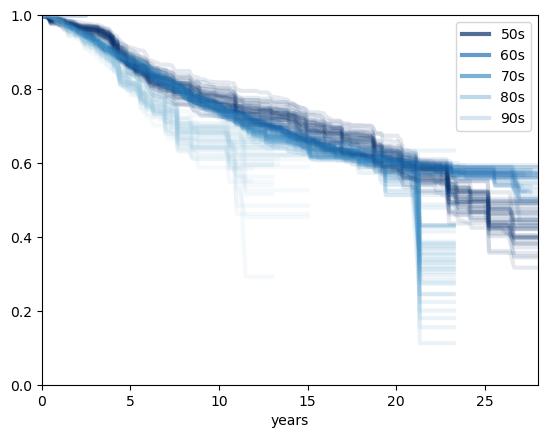

<Figure size 800x600 with 0 Axes>

In [50]:
from __future__ import print_function

import pandas
import numpy as np

import thinkplot
import thinkstats2
import survival

def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    # Replace invalid values in cmdivorcx with NaN
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    # Create a flag for ongoing marriages
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)

    # Calculate duration for divorced marriages
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0

    # Calculate duration so far for ongoing marriages
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    # Handle NaNs in durationsofar (ongoing marriages)
    # Drop rows where durationsofar is NaN (invalid data)
    resp.dropna(subset=['durationsofar'], inplace=True)

    # Add decade of birth
    month0 = pandas.to_datetime('1899-12-15')
    dates = [month0 + pandas.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pandas.DatetimeIndex(dates).year - 1900) // 10

def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Show(root='survival7',
                   xlabel='years',
                   axis=[0, 28, 0, 1])

def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        print(name, len(group))
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration
    ongoing = resp[resp.notdivorced == 1].durationsofar

    # Ensure no NaNs in ongoing durations
    if ongoing.isnull().any():
        raise ValueError("ongoing durations still contain NaNs after cleaning")

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

def main():
    resp6 = survival.ReadFemResp2002()
    CleanData(resp6)
    married6 = resp6[resp6.evrmarry==1]

    resp7 = survival.ReadFemResp2010()
    CleanData(resp7)
    married7 = resp7[resp7.evrmarry==1]

    ResampleDivorceCurveByDecade([married6, married7])

if __name__ == '__main__':
    main()